# Practice Session 2: Eigenfaces

Authors:

    - Luca Franceschi (u199149)
    - Telmo Linacisoro (u198711)

# Eigenfaces and Principal Component Analysis (PCA)
In this notebook, we will explore the concept of Eigenfaces, which are eigenvectors used in the computer vision problem of human face recognition. We will see how PCA can be applied to high-dimensional data like images to reduce the dimensionality while preserving as much variability as possible.

In [9]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

## Images

In [10]:
# Some hyperparameters

# Width and height of resized images
wh = 50

# Number of components of PCA 
num_components = 16

# Number of components in the explained variance plot
num_components_plot = 40

In [11]:
def process_images(relative_path: str, image_shape: tuple = (50, 50, 3)):
    '''
    Preprocesses the images, preparing them for PCA.

    Parameters
    ----------
    relative_path: str
        The relative path from cwd (current working directory) to the dataset.
    image_shape: tuple(int, int, int), optional
        The wanted size of each image and the channels wanted (3 is RGB)

    Returns
    -------
    (imgs, flattened_imgs)
        imgs: list containing images in np.array type
        flattened_imgs: np.array containing the images flattened in row-major order
    '''

    # Get full path to dataset
    folder_path = os.getcwd() + relative_path

    # Open file
    imgs = []
    flattened_imgs = []

    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', 'jpg')):
            with Image.open(folder_path + '/' + filename) as image:

                # Resize and change type to np.array
                image = image.resize(image_shape)
                image_array = np.array(image)

                # Add arrays to lists to return
                imgs.append(image_array)
                flattened_imgs.append(image_array.flatten())
    
    return (imgs, np.array(flattened_imgs))

In [12]:
images, falttened = process_images('/helen_1', (wh, wh))

In [13]:
def display_processed_images(images: np.array):
    '''
    Displays the preprocessed images in a grid

    Parameters
    ----------
    images: np.array
        An array of the images in a two-dimensional array type
    '''
    
    grid_size = int(np.ceil(np.sqrt(len(images))))
    # If there are too many images, do 5 columns and the rest rows.
    # Otherwise display as square
    if grid_size > 5:
        nrows = int(np.ceil(len(images)/5))
        fig, axes = plt.subplots(nrows, 5, figsize=(10, nrows*2))
    else:
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size*2, grid_size*2))

    axes = axes.flatten()

    for i, im in enumerate(images):
        axes[i].imshow(im)

    for ax in axes:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

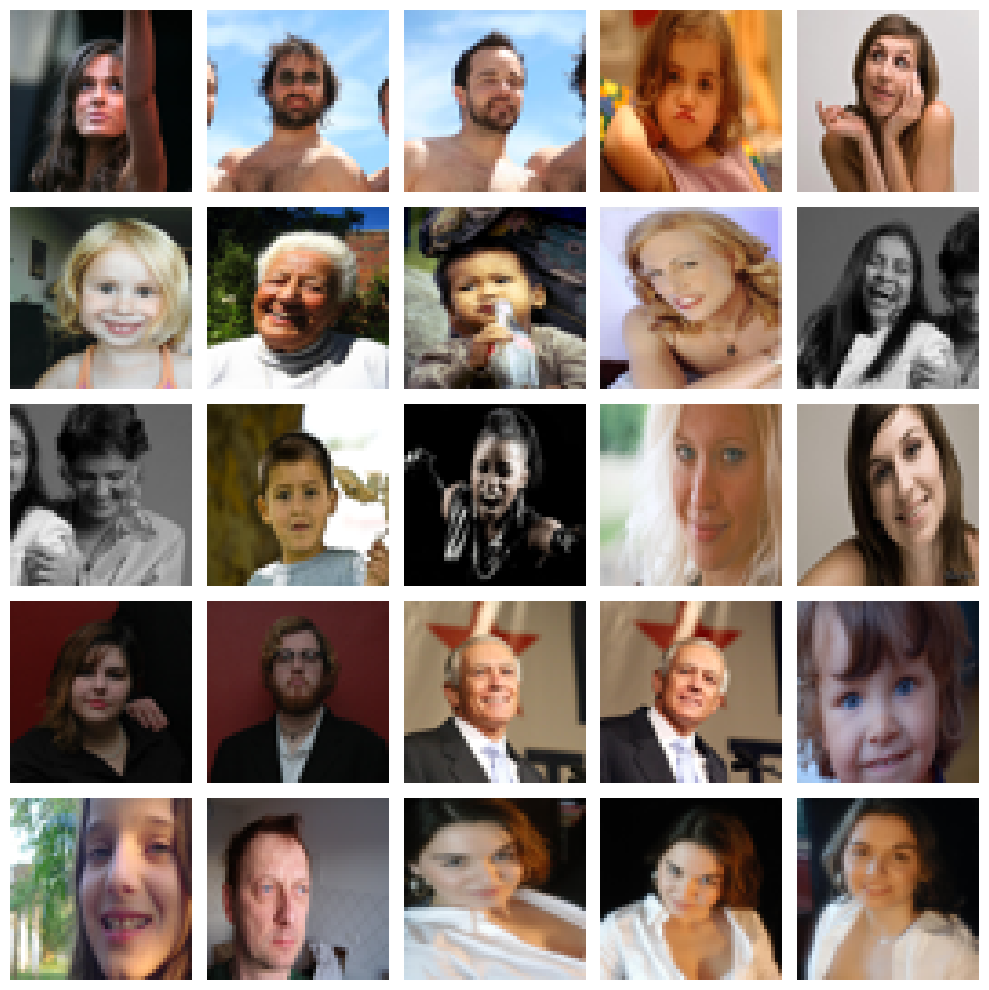

In [14]:
display_processed_images(images[0:25])

In [15]:
def pca(data: np.array, num_components: int = 10):
    '''
    Performs Principal Component Analysis (PCA) on the given data and returns the eigenvalues, eigenvectors, and projected data

    Parameters
    ----------
    data: np.array
        Data array that contains flattened images or landmarks
    num_components: int, optional
        Number of first-selected num_components

    Returns
    -------
    (eigenvalues, eigenvectors, projection)
        eigenvalues: np.array of best num_components eigenvalues
        eigenvectors: np.array of best num_components eigenvectors
        projection: projection of the data onto the eigenspace
    '''
    
    # Normalization
    mean = np.mean(data, axis=0)
    normalized_data = data - mean

    # Covariance matrix
    covariance_matrix = np.cov(normalized_data, rowvar=False) # The variables are columns, the observations are rows (default is reversed)

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # Sort best components (higher eigenvalue means more variance explained in that eigenvector than in others)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    # Take the first num_components from the spectral decomposition
    eigenvectors = eigenvectors[:, :num_components]

    # Project into the new eigenspace
    projected_data = np.dot(normalized_data, eigenvectors)

    return eigenvalues, eigenvectors, projected_data

In [16]:
eigval, eigvec, projection = pca(falttened, num_components=num_components)

In [17]:
def plot_explained_variance(eigenvalues: np.array, num_components: int = 120, type: str = 'all'):
    '''
    Displays two plots to understand the explained variance, a bar plot and a line plot.
    First will normalize the eigenvalues, to know how important is each one, then make the plots

    Parameters
    ----------
    eigenvalues: np.array
        The eigenvalues of the decomposition
    num_components: int, optional
        The number of components in the plot
    type: str, optional
        Type of plot. Can have values 'all', 'line' or 'bar'
    '''

    eigval_sum = sum(eigenvalues)
    explained_variance = np.array([val / eigval_sum for val in eigenvalues])
    explained_cummulative = np.cumsum(explained_variance)

    fig, ax = plt.subplots(figsize=(10, 5))

    if type == 'all':
        ax.bar(range(1, num_components + 1), explained_variance[:num_components], alpha=0.5, align='center', label='Individual explained variance')
        ax.plot(range(1, num_components + 1), explained_cummulative[:num_components], 'r-', lw=2, label='Cumulative explained variance')
        plt.ylim([0, 1])

    elif type == 'line':
        ax.plot(range(1, num_components + 1), explained_cummulative[:num_components], 'r-', lw=2, label='Cumulative explained variance')
        plt.ylim([explained_cummulative[0]-0.1, 1])
    
    elif type == 'bar':
        ax.bar(range(1, num_components + 1), explained_variance[:num_components], alpha=0.5, align='center', label='Individual explained variance')
        plt.ylim([0, explained_variance[0]+0.1])

    ax.set_ylabel('Explained Variance')
    ax.set_xlabel('Components')
    ax.set_title('Explained Variance by PCA Components')

    ax.legend(loc='best')
    plt.tight_layout()
    plt.show()


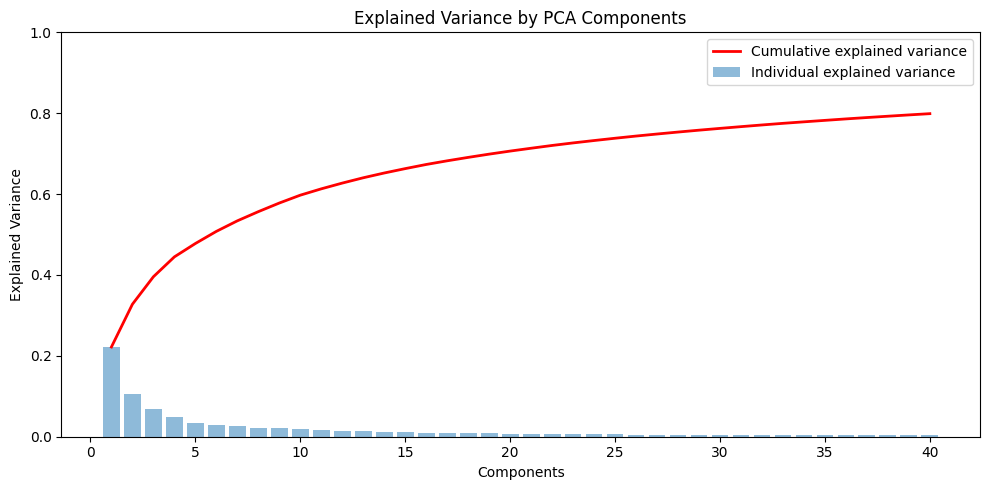

In [18]:
plot_explained_variance(eigval, num_components=num_components_plot)

In [19]:
def display_mean_face(data: np.array,
                      image_shape: tuple = (50, 50, 3)):
    '''
    Displays the mean face coming from the input_vector, with the provided image_shape

    Parameters
    ----------
    data: np.array
        Data array that contains flattened images or landmarks
    image_shape: tuple(int, int, int), optional
        The wanted size of each image and the channels wanted (3 is RGB)
    '''

    mean_image = np.mean(data, axis=0)

    plt.figure(figsize=(6, 6))
    plt.imshow(Image.fromarray(np.uint8(mean_image.reshape(image_shape))))
    plt.title('Mean Face')
    plt.axis('off')
    plt.show()

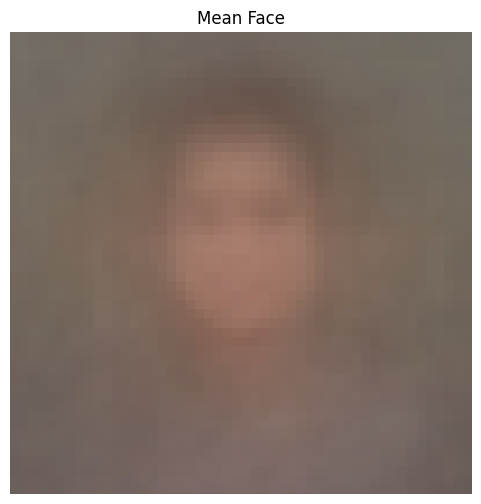

In [20]:
display_mean_face(falttened, image_shape=(wh, wh, 3))

In [21]:
def display_eigenfaces(eigenvectors: np.array,
                       image_shape: tuple = (50, 50, 3),
                       num_components: int = 10):
    '''
    Displays the eigenfaces 

    Parameters
    ----------
    eigenvectors: np.array
        The eigenvectors of the decomposition
    image_shape: tuple(int, int, int), optional
        The wanted size of each image and the channels wanted (3 is RGB)
    num_components: int, optional
        The number of components to display
    '''

    grid_size = int(np.ceil(np.sqrt(num_components)))
    if grid_size > 5:
        nrows = int(np.ceil(num_components/5))
        fig, axes = plt.subplots(nrows, 5, figsize=(10, nrows*2))
    else:
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size*2, grid_size*2))

    axes = axes.flatten()

    for i in range(num_components):
        vec = eigenvectors[:, i]
        vec_norm = 255 * (vec - np.min(vec)) / (np.max(vec) - np.min(vec)) # will display in greyscale [0:255]

        eigenface = vec_norm.reshape(image_shape)
        axes[i].imshow(Image.fromarray(np.uint8(eigenface)), cmap='gray')
        axes[i].set_title('Eigenface {:d}'.format(i+1))
        
    for ax in axes:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

In [22]:
display_eigenfaces(eigvec, num_components=num_components)

KeyboardInterrupt: 

In [ ]:
def display_modes_of_variation(mean_img: np.array,
                               eigenvalues: np.array,
                               eigenvectors: np.array,
                               comp: int = 4,
                               image_shape: tuple = (50, 50, 3),
                               std_devs: np.array = np.arange(-3.0, 3.25, 0.25)):
    '''
    Displays modes of variation of the PCA decomposition

    Parameters
    ----------
    mean_img: np.array
        Mean image of the data
    eigenvalues: np.array
        The eigenvalues of the decomposition
    eigenvectors: np.array
        The eigenvectors of the decomposition
    comp: int, optional
        Component that will vary
    image_shape: tuple(int, int, int), optional
        The wanted size of each image and the channels wanted (3 is RGB)
    std_devs: np.array, optional
        Steps in the standard deviation that will vary
    '''

    grid_size = int(np.ceil(np.sqrt(len(std_devs))))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size*2, grid_size*2))
    axes = axes.flatten()
    
    for i, std in enumerate(std_devs):
        variant = eigenvectors[:, comp] * std * np.sqrt(eigenvalues[comp])
        image_flat = (mean_img + variant)
        image = image_flat.reshape(image_shape)
        # image_norm = 255 * (image - np.min(image)) / (np.max(image) - np.min(image))
        image_norm = np.clip(image, 0, 255)

        axes[i].imshow(Image.fromarray(np.uint8(image_norm)), cmap='gray')
        axes[i].set_title(f'{std:.2f} STDs')

    for ax in axes:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

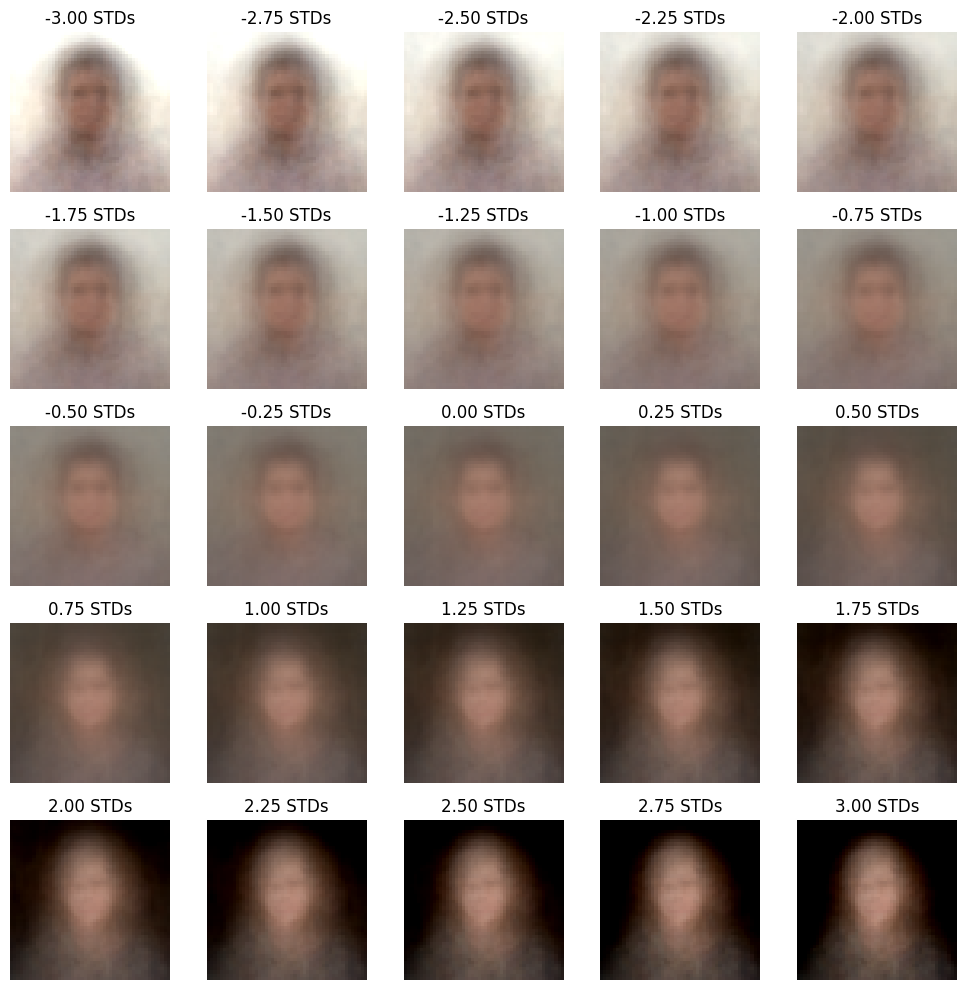

In [ ]:
display_modes_of_variation(np.mean(falttened, axis=0), eigval, eigvec, comp=0)

In [ ]:
def display_reconstruction_comparison(original_images: np.array,
                                      eigenvectors: np.array,
                                      data: np.array,
                                      mean_img: np.array,
                                      image_shape: tuple = (50, 50, 3),
                                      num_components: int = 60,
                                      selected_img: int = 0):
    '''
    Displays the reconstruction of the selected original image component by component

    Parameters
    ----------
    original_images: np.array
        Array of the original preprocessed images
    eigenvectors: np.array
        The eigenvectors of the decomposition
    data: np.array
        Data array that contains flattened images or landmarks
    mean_img: np.array
        Mean image of the data
    image_shape: tuple(int, int, int), optional
        The wanted size of each image and the channels wanted (3 is RGB)
    num_components: int, optional
        Number of components that will be used for the reconstruction
    selected_img: int, optional
        Index of the selected image
    '''
    original = original_images[selected_img]

    grid_size = int(np.ceil(np.sqrt(num_components+1))) # original image goes in idx 0
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size*2, grid_size*2))
    axes = axes.flatten()

    axes[0].imshow(Image.fromarray(np.uint8(original)))
    axes[0].set_title('Original Image')

    for i in range(1, num_components+1):
        vec = eigenvectors[:, :i] # truncate up to i components
        # Project using the first i components
        projection = np.dot(data[selected_img] - mean_img, vec)
        # Reproject using the first i components
        reprojection = np.dot(projection, vec.T) + mean_img

        reconstructed_img = reprojection.reshape(image_shape)
        axes[i].imshow(Image.fromarray(np.uint8(reconstructed_img)), cmap='gray')
        axes[i].set_title('{:d} components'.format(i+1))

    for ax in axes:
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

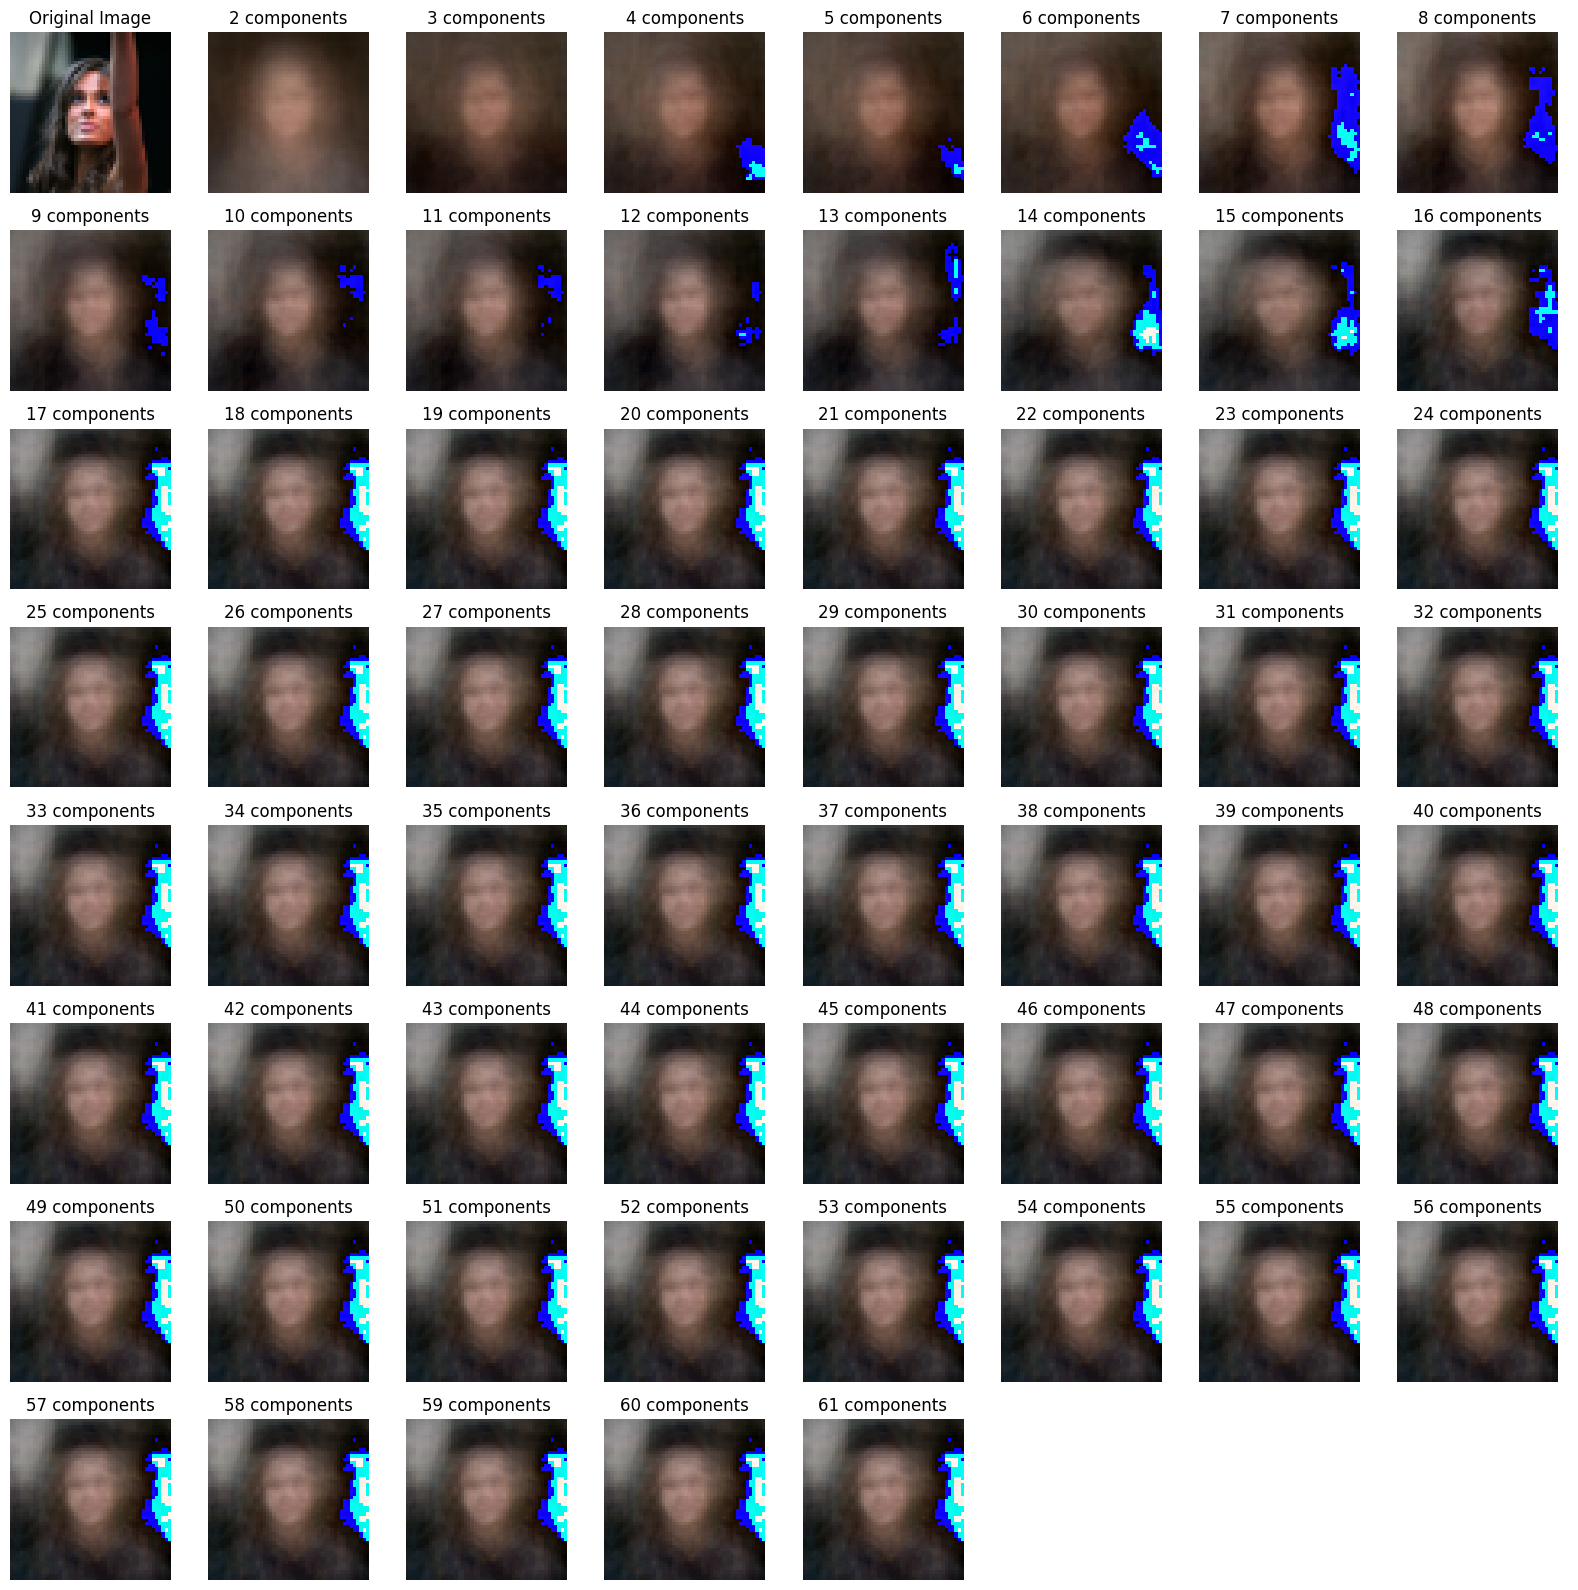

In [ ]:
display_reconstruction_comparison(images, eigvec, falttened, np.mean(falttened, axis=0))

## Landmarks

In [35]:
def process_landmarks(relative_path_images: str, relative_path_landmarks: str, image_shape: tuple = (50, 50)):
    folder_path_images = os.getcwd() + relative_path_images
    folder_path_landmarks = os.getcwd() + relative_path_landmarks

    image_shapes = []

    for filename in os.listdir(folder_path_images):
            if filename.endswith(('.png', 'jpg')):
                with Image.open(folder_path_images + '/' + filename) as image:
                    image_shapes.append(image.size)

    for i, filename in enumerate(os.listdir(folder_path_landmarks)):
        if filename.endswith('.txt'):
            with open(folder_path_landmarks + '/' + filename, 'r', ) as file:
                next(file) # ignore first line
                x, y = file.readline().split(' , ')
                
                reshaped_x = int(np.floor(float(x) * image_shape[0] / image_shapes[i][0]))
                reshaped_y = int(np.floor(float(y) * image_shape[1] / image_shapes[i][1]))
                landmarks = np.zeros(image_shape)
                
                if reshaped_x < 50 and reshaped_y < 50:
                    # print(i)
                    # print(image_shapes[i])
                    # print(x, y)
                    # print(reshaped_x, reshaped_y)
                    landmarks[reshaped_y][reshaped_x] = 1

                # landmarks[reshaped_y][reshaped_x] = 1

    return (landmarks, landmarks.flatten())
    #         with Image.open(folder_path + '/' + filename) as image:

    #             # Resize and change type to np.array
    #             image = image.resize(image_shape)
    #             image_array = np.array(image)

    #             # Add arrays to lists to return
    #             imgs.append(image_array)
    #             flattened_imgs.append(image_array.flatten())
    
    # return (imgs, np.array(flattened_imgs))

In [36]:
landmarks, flatten_landmarks = process_landmarks('/helen_1', '/annotation')

# display_processed_images(landmarks[0:25])
landmarks[0].shape

(50,)